In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from statsforecast import StatsForecast

from statsforecast.models import (
    AutoARIMA,
    HistoricAverage,
    RandomWalkWithDrift,
    SeasonalNaive
)

[08/30/23 18:49:08] WARNING  /home/lineker/indicium/seara_demand_forecast/venv/lib/python3.10/site- ]8;id=461234;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=55308;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using                     
                             `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to                 
                             force console mode (e.g. in jupyter console)                                          
                               from tqdm.autonotebook import tqdm                                                  
                                                                                                                   

In [4]:
df = catalog.load("model_input")

[08/29/23 21:49:55] INFO     Loading data from 'model_input' (CSVDataSet)...                    ]8;id=890751;file:///home/lineker/indicium/seara_demand_forecast/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=455688;file:///home/lineker/indicium/seara_demand_forecast/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
df.head()

,Unnamed: 0,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6


In [6]:
df = df.rename(columns={"Unnamed: 0": "ds"})
df.head()

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6


In [7]:
unique_id = df.columns.tolist()[1:]

In [8]:
Y_df = pd.melt(df, id_vars="ds", value_vars=unique_id, value_name="y", var_name="unique_id")
Y_df.head()

,ds,unique_id,y
0,1980,Afghanistan,0.123529
1,1981,Afghanistan,1.823529
2,1982,Afghanistan,2.423529
3,1983,Afghanistan,2.723529
4,1984,Afghanistan,2.323529


- Checagem do comportamento de algumas séries

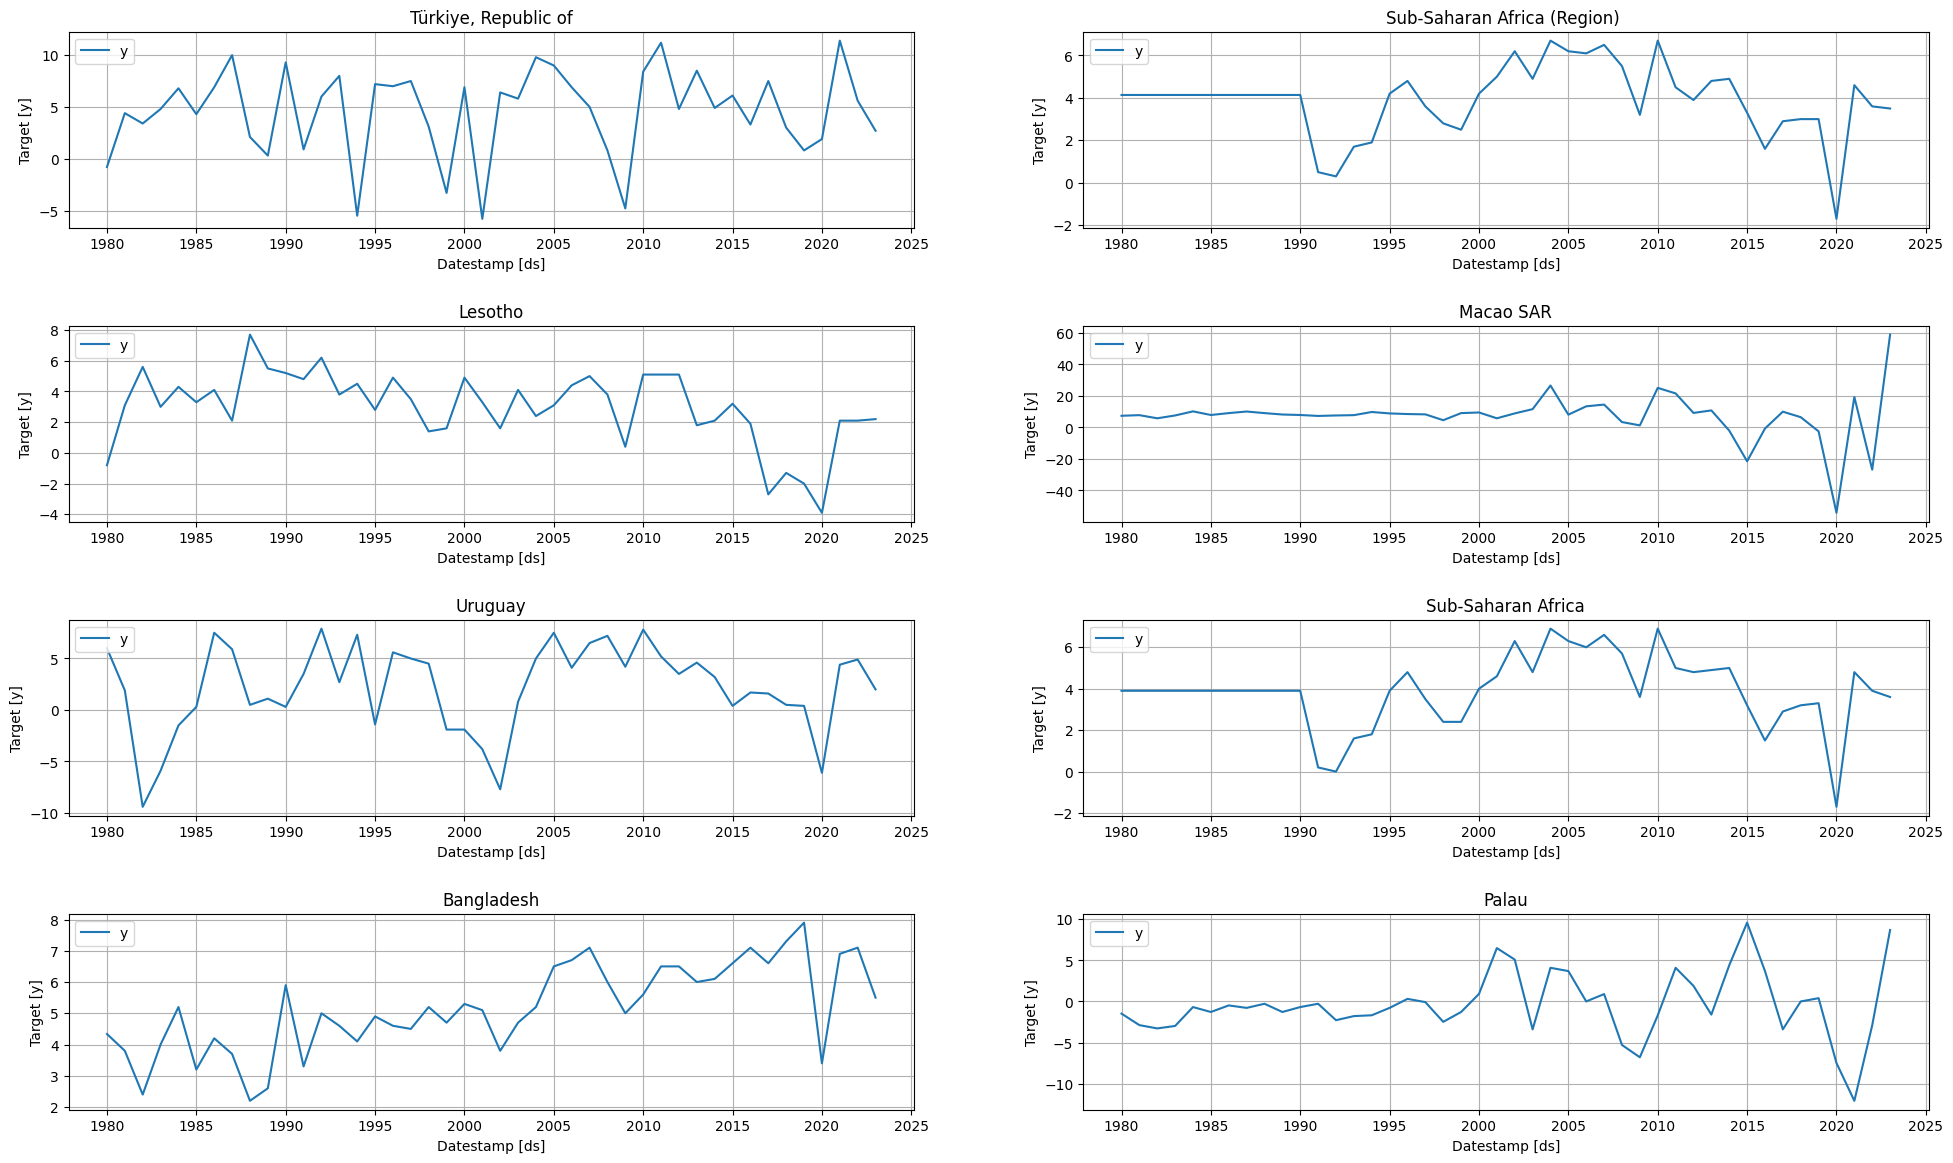

In [9]:
StatsForecast.plot(Y_df, engine="matplotlib")

### Create Models

In [11]:
models = [
    AutoARIMA(season_length=1),
    #SeasonalNaive(season_length=1),
    #HistoricAverage(),
    #RandomWalkWithDrift()
]

In [12]:
sf = StatsForecast(
    df=Y_df, 
    models=models,
    freq='Y', 
    n_jobs=-1,
)

In [13]:
forecasts_df = sf.forecast(h=5, level=[90])